
# Final layer updation of a pre-trained model, if new classes come in the target dataset



## Code Functions used throughout

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras  as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import Counter

In [3]:
def accuracy_per_label(model_name):
  # Predict the labels for the test set
  y_pred = np.argmax(model_name.predict(x_test_full), axis=1)

  # Calculate accuracy for each label (0-9)
  label_accuracies = {}
  for label in range(10):
    # Get indices where the true label is equal to the current label
    label_indices = np.where(y_test_full == label)[0]

    # Get the true and predicted labels for the current label
    y_true_label = y_test_full[label_indices]
    y_pred_label = y_pred[label_indices]

    # Calculate accuracy for the current label
    accuracy = accuracy_score(y_true_label, y_pred_label)
    label_accuracies[label] = accuracy

  # Print the accuracy for each label
  for label, accuracy in label_accuracies.items():
    print(f'Accuracy for label {label}: {accuracy * 100:.2f}%')

  total_accuracy = accuracy_score(y_test_full, y_pred)
  print(f'Total accuracy: {total_accuracy * 100:.2f}%')

  return True

In [4]:
def pred_label_count(model_name):
  # Predict the labels for the test set
  y_pred = np.argmax(model_name.predict(x_test_full), axis=1)

  # Count how many times each label was predicted
  predicted_label_counts = Counter(y_pred)

  # Print the number of times each label was predicted
  for label, count in sorted(predicted_label_counts.items()):
    print(f'Label {label} was predicted {count} times')

In [5]:
# Define an EarlyStopping callback with a custom stopping condition for 100% validation accuracy
class CustomStopping(EarlyStopping):
    def __init__(self, monitor='train_accuracy', value=1.0, verbose=1, **kwargs):
        super(CustomStopping, self).__init__(monitor=monitor, verbose=verbose, **kwargs)
        self.value = value

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None and current >= self.value:
            self.stopped_epoch = epoch
            self.model.stop_training = True

# Use CustomStopping callback to stop training at 100% test accuracy
early_stopping_accuracy = CustomStopping(monitor='train_accuracy', value=1.0, verbose=1)

# Using EarlyStopping based on validation loss with a patience parameter
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)



In [6]:

def show_misclassified_samples(model, x_test, y_test, num_samples=5):
    """
    Displays the misclassified samples from the test set.

    Parameters:
    - model: Trained model
    - x_test: Test data
    - y_test: True labels for the test data
    - num_samples: Number of misclassified samples to display (default: 5)
    """
    # Get the model's predictions
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Find the indices of misclassified samples
    misclassified_indices = np.where(y_pred != y_test)[0]

    # If there are no misclassified samples
    if len(misclassified_indices) == 0:
        print("All samples were classified correctly.")
        return

    # Display the number of misclassified samples
    print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(x_test)}")

    # Display a few misclassified samples (up to 'num_samples')
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(misclassified_indices[:num_samples]):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_test[index]}, Pred: {y_pred[index]}")
        plt.axis('off')

    plt.show()

## Final Results (MNIST with DNN)

| Model No. |Training Labels|Output Neurons| Basic Model low / full| Naive Change Model | Retrained last layer Model | Fully Retrained (Transfer Learning) |
| :- |:--:|:--:| :-------------------------: | :-----------: | :-----------: |:-----------: |
| 1. | 10 | 10 | 0.9822 / 0.9804 | Same | 0.9824 / 0.9812 | 0.9819 / 0.9799 |
| 2. | 8  | 8  | 0.9864 / 0.7865 | 0.0441 / 0.0441 | 0.9683 / 0.9609 |  0.9784 / 0.9775  |

0.6401 / 0.5343 for normally distributed weights on extra neurons

## Final Comparitive Results
(lower input with Higher Output 8/10 case)

| Type of model | MNIST with CNN | MNIST 8/8 | CIFAR10 with CNN| CIFAR10 8/8 |MNIST with DNN | MNIST 8/8 |
| :- |:--:|:--:| :-------------------------: | :---: |:--:|:--:|
| Basic Model                        | 0.9896 / 0.7933 | 0.9936 / 0.7965 | 0.6990 / 0.5591	| 0.6629 / 0.5303	| 0.9822 / 0.9804	|	0.9864 / 0.7865 |
| Naive Change Model                 | 0.0051 / 0.0046 | 0.0834 / 0.0795 | 0.1558 / 0.1682 | 0.2137 / 0.1899	| Same | 0.0441 / 0.0441	|
| Retrained last layer Model         | 0.9874 / 0.9839 | 0.9903 / 0.9865 | 0.6736 / 0.6133	| 0.6687 / 0.6075	| 0.9824 / 0.9812 |  0.9683 / 0.9609|
| Fully Retrained (Transfer Learning)| 0.9918 / 0.9897 | 0.9909 / 0.9902 | 0.6698 / 0.6995 | 0.7101 / 0.7268 | 0.9819 / 0.9799 |	0.9784 / 0.9775 |

## Conclusion


Same results as https://www.amazon.science/blog/updating-neural-networks-to-recognize-new-categories-with-minimal-retraining#:~:text=The%20first%20transfer%2Dlearning%20method,that%20uses%20the%20neural%20adapter.

 the most effective technique is to keep the original classifier; pass its output through a separate network,

 For both initial architectures and both transfer-learning methods, we considered the case in which we allowed only the weights of the top few layers to vary during retraining and the case in which we allowed the weights of the entire network to vary. Across the board, allowing all the weights to vary offered the best performance.

 More Approaches - Ensemble based Approach, on older data model (few classes) and newer data model (all classes)

References :
* https://ai.stackexchange.com/questions/3981/is-it-possible-to-train-a-neural-network-as-new-classes-are-given

* Chen, L., & Moschitti, A. (2019). Transfer learning for sequence labeling using source model and target data. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01), 6260–6267. https://doi.org/10.1609/aaai.v33i01.33016260

* https://stackoverflow.com/questions/50366160/re-train-model-with-new-classes?rq=3
Related section has more similar failed results.
* https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

Similar implementation -
* J. Zhang, F. Li, H. Wu and F. Ye, "Autonomous Model Update Scheme for Deep Learning Based Network Traffic Classifiers," 2019 IEEE Global Communications Conference (GLOBECOM), Waikoloa, HI, USA, 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9014036 .
*  J. Zhang, F. Li, F. Ye and H. Wu, "Autonomous Unknown-Application Filtering and Labeling for DL-based Traffic Classifier Update," IEEE INFOCOM 2020 - IEEE Conference on Computer Communications, Toronto, ON, Canada, 2020, pp. 397-405, doi: 10.1109/INFOCOM41043.2020.9155292 .


##  General Implementation

In [7]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

print(len(x_train_full))
print(len(x_test_full))
print(len(y_train_full))
print(len(y_test_full))

60000
10000
60000
10000


### Creating  the variables


Full = All labels

Low = Labels 0-7

High = Labels 8,9

* x_train_full, x_test_full - **Original full testing dataset**
* x_train, x_test - **Train and Validation dataset**
* y_train_low, y_train_high
* y_test_low, y_test_high
* x_train_low, x_train_high
* x_test_low, x_test_high

In [8]:
# Normalize the data (0-255 to 0-1)
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0

# Flatten the images for the CNN model
x_train_full = x_train_full.reshape(-1, 28, 28, 1)
x_test_full = x_test_full.reshape(-1, 28, 28, 1)

# Creating indices where the labels are in the range 0-7 : low, 8,9 : high
test_low_indices = np.where(y_test_full < 8)[0]
test_high_indices = np.where(y_test_full >= 8)[0]

x_test_low = x_test_full[test_low_indices]
y_test_low = y_test_full[test_low_indices]

x_test_high = x_test_full[test_high_indices]
y_test_high = y_test_full[test_high_indices]

# Split the full training set into train and test sets with 80-20 split using a seed value
# Creating a training and validation set together
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.20, random_state=42)

In [9]:
print(len(x_test_full))
print(len(x_test_low))
print(len(x_test_high),"\n")

print(len(y_test_full))
print(len(y_test_low))
print(len(y_test_high))

10000
8017
1983 

10000
8017
1983


In [10]:
# Create train_low (labels 0-7) and train_high (labels 8-9) from x_train
train_low_indices = np.where(y_train < 8)[0]
train_high_indices = np.where(y_train >= 8)[0]

x_train_low = x_train[train_low_indices]
y_train_low = y_train[train_low_indices]

x_train_high = x_train[train_high_indices]
y_train_high = y_train[train_high_indices]

val_low_indices = np.where(y_val < 8)[0]
val_high_indices = np.where(y_val >= 8)[0]

x_val_low = x_val[val_low_indices]
y_val_low = y_val[val_low_indices]

x_val_high = x_val[val_high_indices]
y_val_high = y_val[val_high_indices]

In [11]:
print(len(x_train))
print(len(x_train_low))
print(len(x_train_high),"\n")

print(len(y_train))
print(len(y_train_low))
print(len(y_train_high),"\n")

print(len(x_val))
print(len(x_val_low))
print(len(x_val_high),"\n")

print(len(y_val))
print(len(y_val_low))
print(len(y_val_high),"\n")

48000
38554
9446 

48000
38554
9446 

12000
9646
2354 

12000
9646
2354 



## 2. 8  labels - 8 outputs

In [12]:

# Define the initial model with 8 output neurons (for classes 0-7)
initial_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # 8 classes for 0-7
])

initial_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_model.fit(x_train_low, y_train_low, epochs=5, validation_data=(x_val_low, y_val_low), batch_size=64)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.9111 - loss: 0.3067 - val_accuracy: 0.9830 - val_loss: 0.0573
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.9845 - loss: 0.0482 - val_accuracy: 0.9867 - val_loss: 0.0438
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9911 - loss: 0.0283 - val_accuracy: 0.9872 - val_loss: 0.0434
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9950 - loss: 0.0165 - val_accuracy: 0.9908 - val_loss: 0.0313
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0.9912 - val_loss: 0.0313


In [23]:
# Step 1: Calculate Fisher Information Matrix excluding the last layer's weights
def calculate_fisher_information(model, data, labels, batch_size=64):
    fisher_information = [np.zeros(layer.shape) for layer in model.trainable_weights[:-1]]  # Exclude last layer
    num_batches = len(data) // batch_size
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]

        with tf.GradientTape() as tape:
            predictions = model(batch_data)
            loss = tf.keras.losses.sparse_categorical_crossentropy(batch_labels, predictions)

        gradients = tape.gradient(loss, model.trainable_weights[:-1])  # Exclude last layer
        for j, layer in enumerate(model.trainable_weights[:-1]):
            fisher_information[j] += np.square(gradients[j].numpy()) / num_batches
    return fisher_information

# Recalculate fisher information and old weights without the last layer
fisher_information = calculate_fisher_information(initial_model, x_train_low, y_train_low)
old_weights = [layer.numpy() for layer in initial_model.trainable_weights[:-1]]  # Exclude last layer

# Step 2: Modify the EWC loss function to use the adjusted fisher_information and old_weights
lambda_ewc = 0.5

def ewc_loss(model, x, y):
    predictions = model(x)
    standard_loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)

    ewc_penalty = 0
    for i, layer in enumerate(model.trainable_weights[:-1]):  # Exclude last layer
        ewc_penalty += tf.reduce_sum(fisher_information[i] * tf.square(layer - old_weights[i]))
    ewc_penalty *= (lambda_ewc / 2)

    return standard_loss + ewc_penalty

# Custom training loop to apply EWC loss
class EWCLossModel(tf.keras.Sequential):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            loss = tf.reduce_mean(ewc_loss(self, x, y))
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

# Initialize EWC model using the layers from second_model
ewc_model = EWCLossModel(second_model.layers)  # Pass layers directly
ewc_model.compile(optimizer='adam', metrics=['accuracy'])

# Train the model on classes 8-9 with EWC regularization
ewc_model.fit(x_train_high, y_train_high, epochs=5, validation_data=(x_val_high, y_val_high))


Epoch 1/5


ValueError: Dimensions must be equal, but are 10 and 8 for '{{node sub_4}} = Sub[T=DT_FLOAT](ReadVariableOp_4, Const_8)' with input shapes: [128,10], [128,8].

In [19]:

# Custom training loop to apply EWC loss
class EWCLossModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            loss = tf.reduce_mean(ewc_loss(self, x, y))
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

# Use the second model architecture for EWC training
ewc_model = EWCLossModel(inputs=second_model.input, outputs=second_model.output)
ewc_model.compile(optimizer='adam', metrics=['accuracy'])

# Train the model on classes 8-9 with EWC regularization
ewc_model.fit(x_train_high, y_train_high, epochs=5, validation_data=(x_val_high, y_val_high))

ValueError: The layer sequential_4 has never been called and thus has no defined input.

### Results

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Total misclassified samples: 147 out of 8017


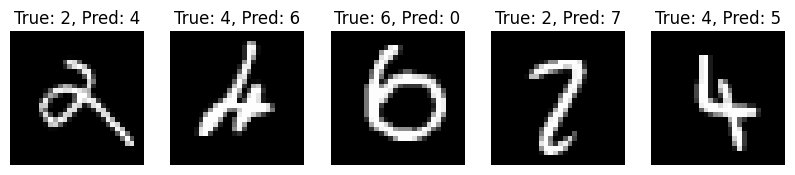

In [ ]:
show_misclassified_samples(model_2,x_test_low,y_test_low)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(x_test_low, y_test_low)
print(f'Test accuracy over low dataset: {test_acc}, Test loss acc: {test_loss}')

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0831
Test accuracy over low dataset: 0.9816639423370361, Test loss acc: 0.07553794980049133


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(x_test_full, y_test_full)
print(f'Test accuracy over whole dataset: {test_acc}, Test loss acc: {test_loss}')

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-17-d952445dda52>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 343, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 85, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 357, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 325, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 1853, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 645, in sparse_categorical_crossentropy

Received a label value of 9 which is outside the valid range of [0, 8).  Label values: 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_5880]

In [ ]:
accuracy_per_label(model_2)

In [ ]:

pred_label_count(model_2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Label 0 was predicted 1057 times
Label 1 was predicted 1187 times
Label 2 was predicted 1136 times
Label 3 was predicted 1304 times
Label 4 was predicted 1571 times
Label 5 was predicted 1338 times
Label 6 was predicted 994 times
Label 7 was predicted 1413 times
